In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.feature_extraction.image import extract_patches_2d


device = torch.device('cpu')

In [162]:
class Classifier(nn.Module):
    def __init__(self, in_channels=3,out_classes=10):
        super(Classifier, self).__init__()
        hidden_dim = 64
        self.conv1 = nn.Conv2d(in_channels,hidden_dim,kernel_size=4,stride=4)
        #self.conv2 = nn.Conv2d(hidden_dim,hidden_dim,kernel_size=4,stride=2)
        self.conv3 = nn.Conv2d(hidden_dim,hidden_dim,kernel_size=3,padding=1,stride=2)
        self.linear_final = nn.Linear(4*4*hidden_dim,out_classes)

    def forward(self,x):
        x = self.conv1(x).clamp(min=0)
        #x = self.conv2(x).clamp(min=0)
        x = self.conv3(x).clamp(min=0)
        x = self.linear_final(x.view(x.shape[0],-1))
        return x

In [146]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data_,label_ = [],[]
for i in range(1,6):
    data = unpickle('cifar-10-batches-py/data_batch_%d'%i)
    data_.append(np.array(data[b'data']))
    label_.append(np.array(data[b'labels']))
data = np.concatenate(data_,axis=0)
label = np.concatenate(label_,axis=0)

class myDataset(torch.utils.data.Dataset):
    def __init__(self,data,label,rand_label):
        self.data = data
        self.label = label
        self.rand_label = rand_label
        r = self.data[:,:1024].reshape((self.data.shape[0],1,32,32))
        g = self.data[:,1024:2048].reshape((self.data.shape[0],1,32,32))
        b = self.data[:,2048:].reshape((self.data.shape[0],1,32,32))
        self.data = np.concatenate([r,g,b],axis=1)/255
        
    def __getitem__(self,index):
        return torch.FloatTensor(self.data[i]), self.label[i], self.rand_label[i]
    def __len__(self):
        return self.data.shape[0]
    
batch_size = 64
train_set = myDataset(data,label,np.random.permutation(label))

In [157]:
data_33 = []
for i in range(len(train_set_random)):
    data_33.append(extract_patches_2d(train_set_random[i][0].numpy().transpose(1,2,0), (4,4)))
    
data_33 = np.concatenate(data_33,axis=0)
covData = np.cov(data_33.reshape((data_33.shape[0],-1)).T)
DataVecs = np.linalg.eig(covData)[1].T
DataVals = np.linalg.eig(covData)[0]
RandomVecs = np.random.normal(size=DataVecs.shape)
RandomVecs = RandomVecs/np.linalg.norm(RandomVecs,axis=1,keepdims=True)

In [144]:
def misaligment(covariance,eigenvecs):
    incovariance = np.linalg.inv(covariance)
    score = 0
    for i in range(eigenvecs.shape[0]):
        score += np.sqrt((eigenvecs[i:i+1,:]@(covariance@eigenvecs[i:i+1,:].T))*(eigenvecs[i:i+1,:]@(incovariance@eigenvecs[i:i+1,:].T)))-1
    return score[0][0]


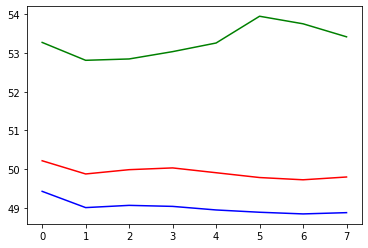

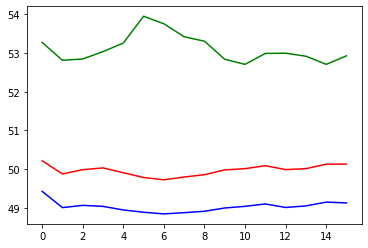

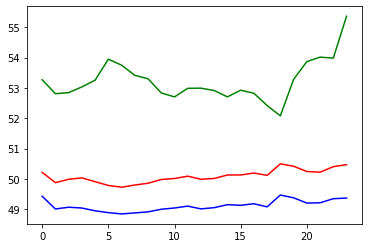

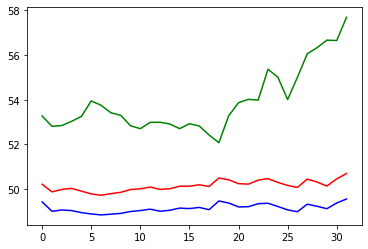

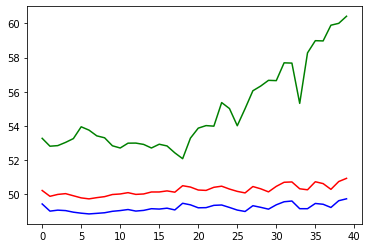

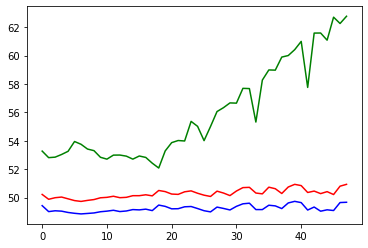

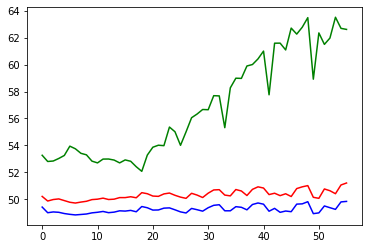

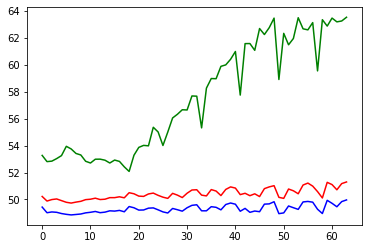

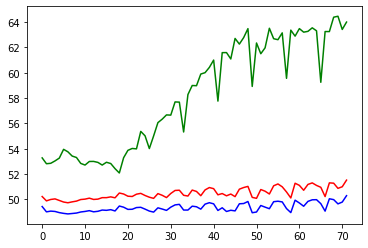

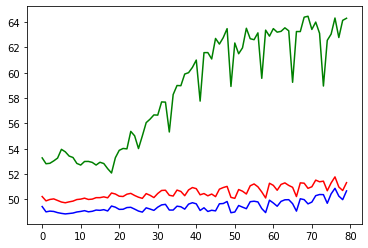

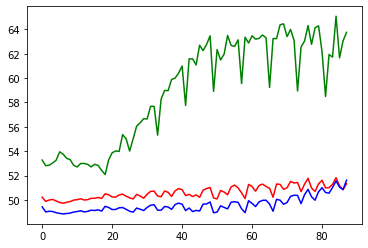

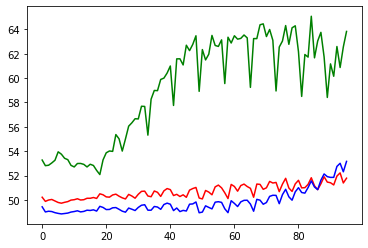

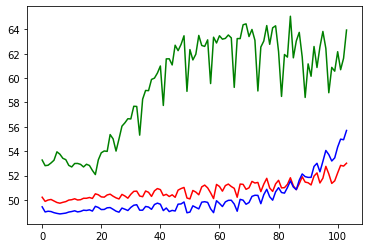

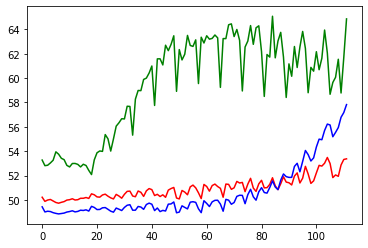

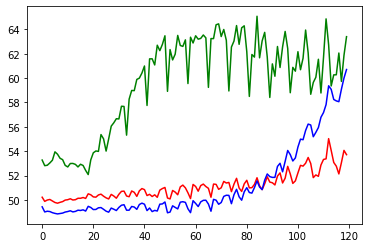

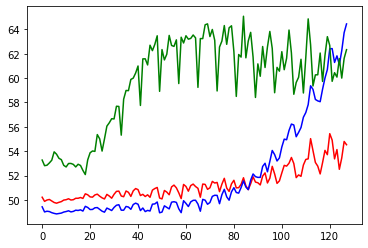

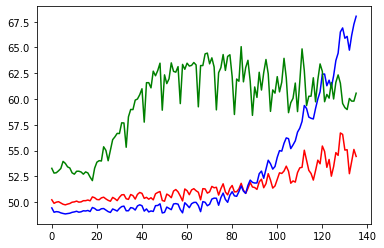

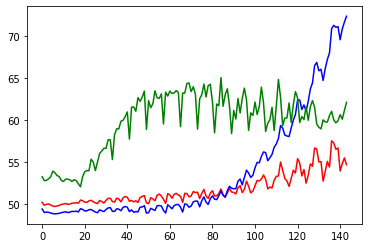

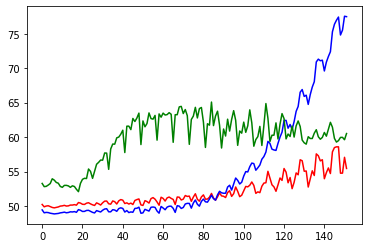

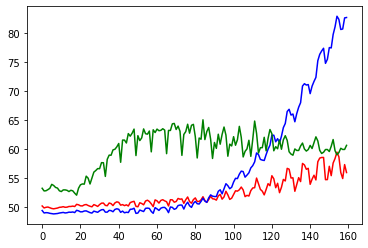

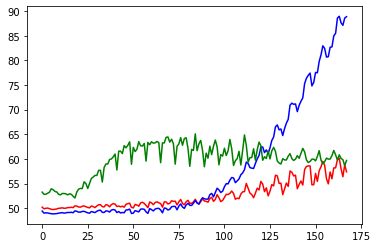

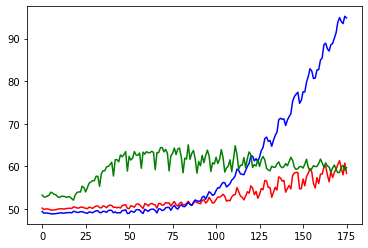

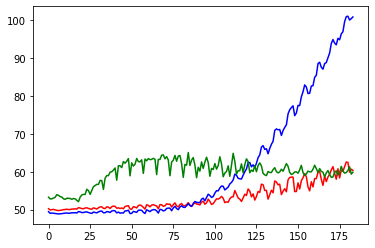

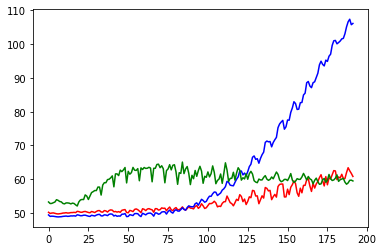

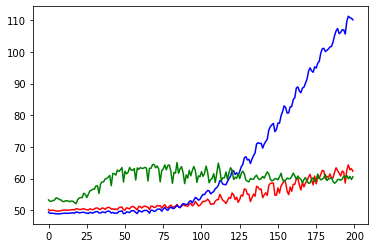

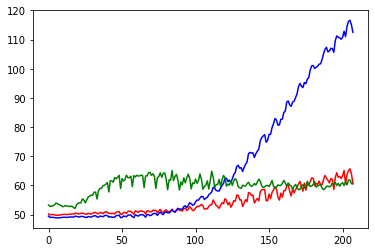

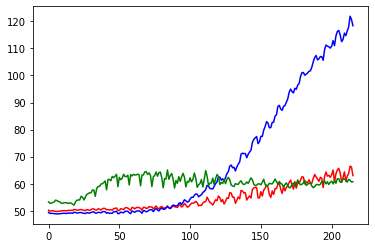

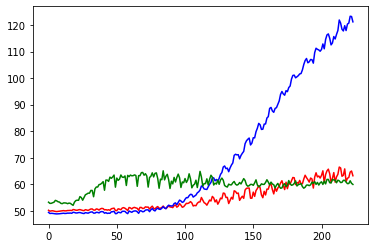

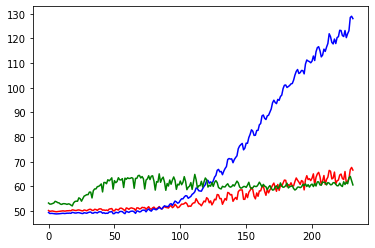

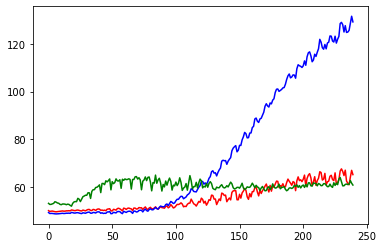

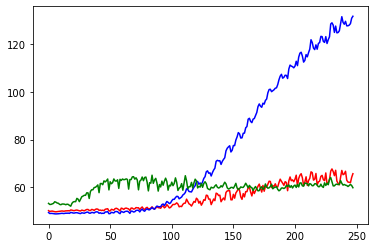

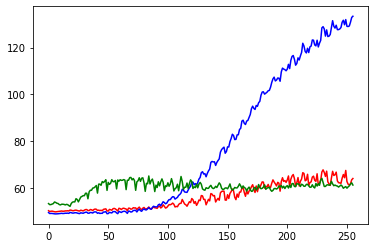

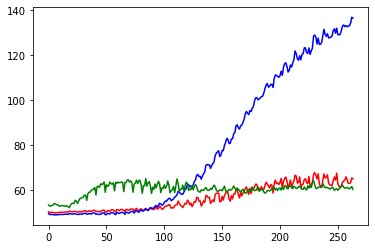

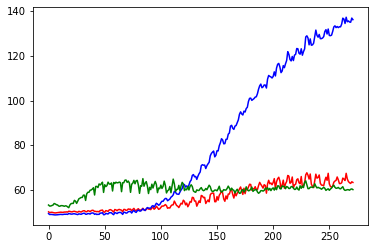

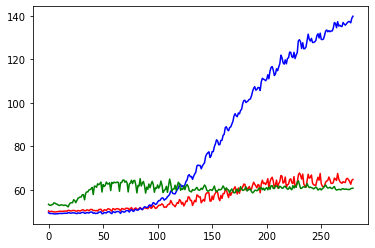

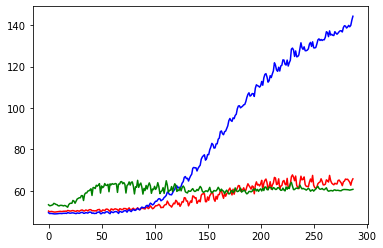

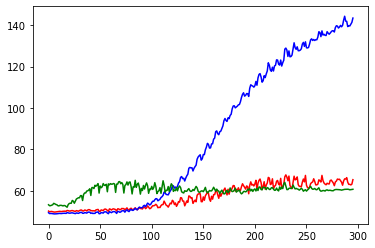

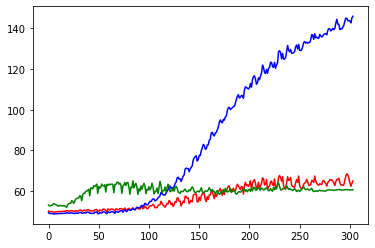

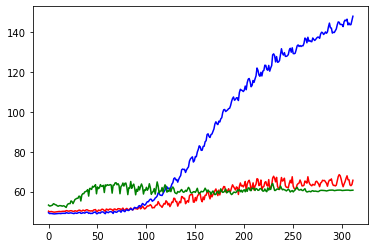

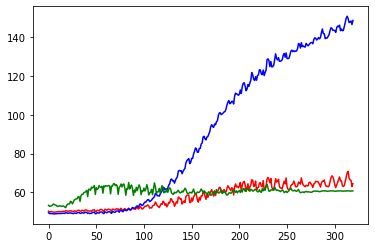

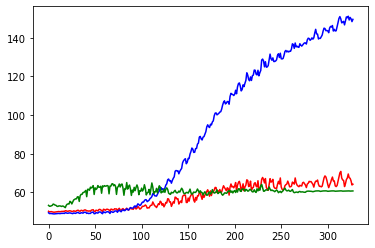

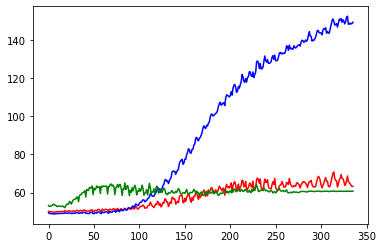

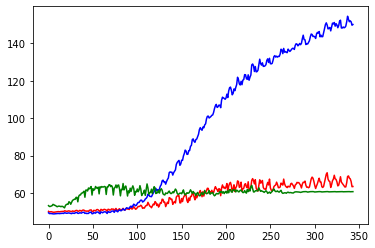

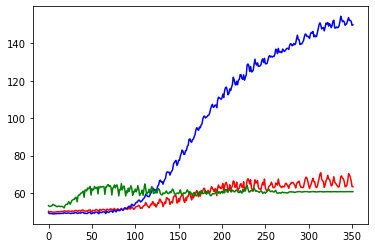

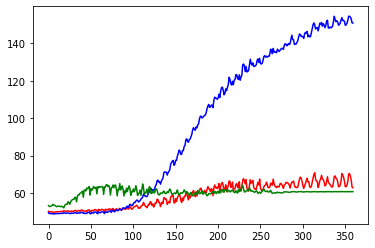

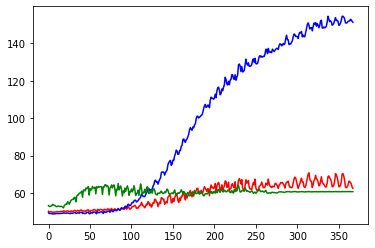

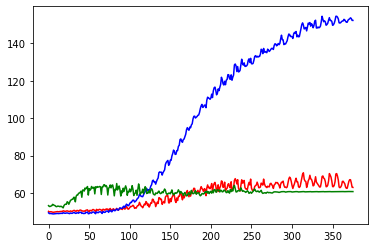

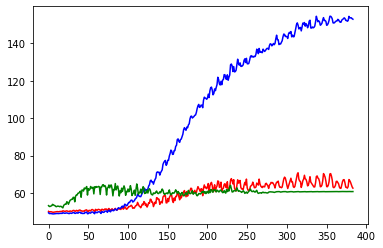

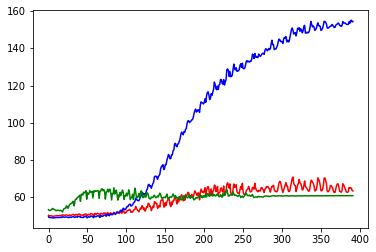

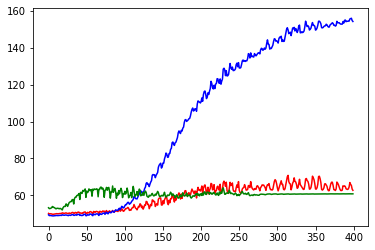

In [163]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size = batch_size,drop_last = False,shuffle=True)
model_random = Classifier()
model = Classifier()
optimizer = torch.optim.SGD(list(model.parameters())+list(model_random.parameters()),lr=1e-2)
lossfn = torch.nn.CrossEntropyLoss()
alignment_eigen_random,alignment_random_random,alignment_eigen_real= [],[],[]
maxEpoch = 50

for _ in range(maxEpoch):
    for i,(x,y,yrand) in enumerate(train_loader):
        y_pred = model(x)
        yrand_pred = model_random(x)
        loss = lossfn(y_pred,y)+lossfn(yrand_pred,yrand)
        optimizer.zero_grad()
        loss.backward()
        #print (loss)
        optimizer.step()
        if (i%100 == 0):
            for x in model_random.conv1.parameters():
                covDataFilters = np.cov(x.detach().numpy().transpose(0,2,3,1).reshape((x.shape[0],-1)).T)
                break
            alignment_eigen_random.append(misaligment(covDataFilters,DataVecs))
            alignment_random_random.append(misaligment(covDataFilters,RandomVecs))
            
            for x in model.conv1.parameters():
                covDataFilters = np.cov(x.detach().numpy().transpose(0,2,3,1).reshape((x.shape[0],-1)).T)
                break
            alignment_eigen_real.append(misaligment(covDataFilters,DataVecs))
    
    plt.plot(np.array(alignment_eigen_random),c='r')
    plt.plot(np.array(alignment_random_random),c='b')
    plt.plot(np.array(alignment_eigen_real),c='g')
    plt.show()


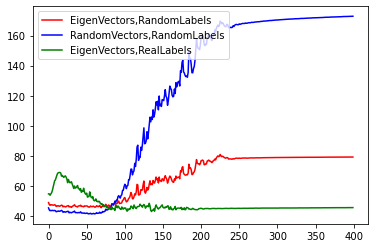

In [138]:
plt.plot(np.array(alignment_eigen),c='r')
plt.plot(np.array(alignment_random),c='b')
plt.plot(np.array(alignment_real),c='g')
plt.legend(["EigenVectors,RandomLabels","RandomVectors,RandomLabels","EigenVectors,RealLabels"], loc ="upper left")
plt.show()

In [ ]:
for i,(x,y) in enumerate(zip([1,2],[2,3])):
    print 